In [2]:
import os                                # os.path.join(), os.listdir(), os.makedirs() is different from os.mkdir() because first can create nested dirs as well
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import cv2
import shutil
from IPython.display import Image        # to use sometimes in place of plt.imshow()
# import tarfile
# import PIL.
# from tqdm.notebook import tqdm
# import opendatasets as O

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset        # TensorDataset, random_split  ==> 'Dataset' enables custom Datasets(imagefolder/tensordataset), dataloaders and transforms
import torchvision
from torchvision.datasets import ImageFolder            # ImageFolder + datasets like mnist, cifar10 ... get imported from here
#from torchvision.datasets.utils import download_url    # or for google+kaggle datasets ==> !pip install opendatasets --upgrade --quiet ==> import opendatasets as op ==> op.download(url)
from torchvision.utils import make_grid, save_image
import torchvision.transforms as T             # Compose([]), ToTensor(), Normalize(), and for data augmentation -> CenterCrop(), Resize(), RandomCrop(), RandomResizedCrop(), RandomHorizontalFlip(), RandomRotate(), ColorJitter()

manualSeed = 999                       # Set random seed for reproducibility #manualSeed = random.randint(1, 10000) # use if you want new results                                   
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#shutil.rmtree('./resized')             # to delete non empthy directories #ზიპ ფაილებს პირდაპირ ზედ დაკლიკებითშლი ერთი ფაილი რახანაა


Random Seed:  999


In [3]:
def device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
device = device()

def todevice(data_model, device):
  if isinstance(data_model, (list, tuple)):
    return [todevice(i, device) for i in data_model]
  return data_model.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dataloader, device):
    self.dataloader = dataloader
    self.device = device

  def __iter__(self):
    for batch in self.dataloader:
      yield todevice(batch, self.device)

  def __len__(self):
    return len(self.dataloader)


In [ ]:
# !pip install opendatasets --upgrade --quiet                    # downloading with openatasets
# url = 'https://www.kaggle.com/ipythonx/van-gogh-paintings'     
# O.download(url)  

# from zipfile import ZipFile                                    # loading from zip 
# file_name = './archive.zip'
# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done, now refresh the Files')

! pip install -q kaggle                                         # directdownload from kaggle but first upload Apikey in files
! mkdir ~/.kaggle                                               # https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ , https://www.kaggle.com/general/74235 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download <name-of-competition>
! kaggle datasets download ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time


In [6]:
dir = './img'          # this contains another folder 'images' so ./img/imagefolder(s), but we want to have one(more) unnested folder(s) wrapping all images for ImageFolder()
imagesize = 64
batchsize = 128

dataset =      ImageFolder(root=dir,
                           transform=T.Compose([
                               T.Resize(imagesize),
                               T.CenterCrop(imagesize),
                               T.ToTensor(),
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))       

trainloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=2, pin_memory=True)
trainload = DeviceDataLoader(trainloader, device)

#we do not have validation and test processes like in other casses, but kinda substitute is tracking of change of same images

 There are 877 pictures in ./img/Vincent_van_Gogh folder
First 10 images are ['Vincent_van_Gogh_443.jpg', 'Vincent_van_Gogh_792.jpg', 'Vincent_van_Gogh_656.jpg', 'Vincent_van_Gogh_297.jpg', 'Vincent_van_Gogh_652.jpg', 'Vincent_van_Gogh_700.jpg', 'Vincent_van_Gogh_196.jpg', 'Vincent_van_Gogh_395.jpg', 'Vincent_van_Gogh_187.jpg', 'Vincent_van_Gogh_503.jpg']
image shape is torch.Size([3, 64, 64])


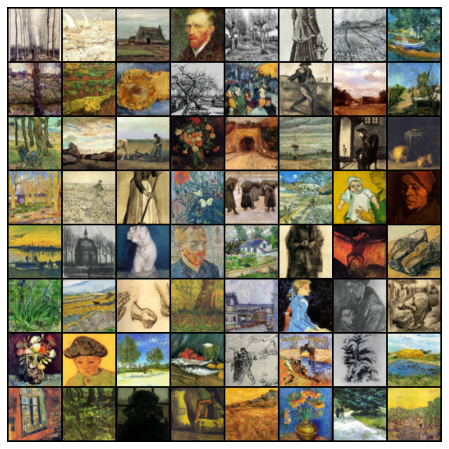

In [7]:
print(f" There are {len(os.listdir(dir + '/Vincent_van_Gogh'))} pictures in {dir}/Vincent_van_Gogh folder")
print(f"First 10 images are {os.listdir(dir + '/Vincent_van_Gogh')[:10]}")

image, _ = dataset[0]
print(f"image shape is {image.shape}") 

def gridofimages(dataload):                        # without for+break images = next(iter(dataload))
  for images, _ in dataload:
    plt.figure(figsize=(8, 8))
    plt.imshow(make_grid(images[:64].cpu().detach(), normalize=True, nrow=8).permute(1, 2, 0))   #images.cpu() because we used dataload (which is on gpu, if gpu is available) not dataloader
    plt.axis('off')
    break
                                                   # normalize=True reverses/unnormalizes what transforms.Normalize has done
gridofimages(trainload)

In [10]:
torch.cuda.empty_cache()

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.discriminator =  nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias=False),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),

#             nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias=False),

#             # for wasserstein loss we do not have the nn.Sigmoid() anymore as we do not compress everything between 0-1       
#         )

#     def forward(self, input):
#         return self.discriminator(input)


# latentsize = 128
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.generator = nn.Sequential(
#             nn.ConvTranspose2d(latentsize, 512, kernel_size=4, stride=1, padding=0, bias=False),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),

#             nn.Tanh() 
#         )
    
#     def forward(self, input):
#         return self.generator(input)

###########--------------Better Alternative Uses Upsampling+Conv2d instead ConvTranspose2d---------------#############


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.mainmodel = nn.Sequential(                                         #we could define function above nn.sequential to write smaller code, but I want to see the whole layers for better learning the structure
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),               # like this: def discriminator_block(inputs, outputs, bn=True): block = [nn.Conv2d(inputs, outputs, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)] if bn: block.append(nn.BatchNorm2d(out_filters, 0.8)) return block
            nn.LeakyReLU(0.2, inplace=True),                                    # and use it like this: self.a = nn.Sequential( *discriminator_block(input, 16, bn=False),...)
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32, 0.8),                   # instead defaul 1 we used 0.8 that basicaly cuts down colorchanel values
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),                   
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),                                           # here dimensions are batch * (128, 4, 4)
            nn.Dropout(0.25),
        )
        self.lastlayer = nn.Sequential(nn.Linear(128*4*4 , 1))

    def forward(self, input):
      out = self.mainmodel(input)
      out = out.view(out.size(0), -1)                                           # So here dimensions are out.view(out.size(0)=batchsize and 128*4*4
      dicriminatorresult = self.lastlayer(out)                                
      return dicriminatorresult                                                 # So here each element in batch sized 128*4*4 gives 1 result for each batch


latentsize = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()       
        self.firstlayer = nn.Sequential(nn.Linear(latentsize, 256*8*8))         # this kind of separating layer allows us easy manipulations on then like shape changes/views of matricies
        self.mainmodel = nn.Sequential(                                         
            nn.BatchNorm2d(256),                                                # No change in factor 1 to 0.8

            nn.Upsample(scale_factor=2),                                        
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),                                        # This revercereacts on kernelsize=3 and means that you do interpolation based on your result pixels, which will have 2 pixels distance to fill those pixels with interpolation results
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),                                    # here generator also uses leakyrelu! like discriminator!
            
            nn.Upsample(scale_factor=2),                                        
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),                                     
            
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),               # we started with 256,8,8 and ended with 3,64,64
            nn.Tanh()
        )
    
    def forward(self, input):
      out = self.firstlayer(input.view(input.size(0), 1, 1, latentsize))
      out = out.view(out.size(0),  256, 8, 8)                                  # out.size(0) = batchsize
      generatorresult = self.mainmodel(out) 
      return generatorresult


Discriminator = todevice(Discriminator(), device)
Generator = todevice(Generator(), device)


# def custom_weights(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#     if isinstance(m, nn.BatchNorm2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#         torch.nn.init.constant_(m.bias, 0)

# Discriminator.apply(custom_weights)
# Generator.apply(custom_weights)

In [ ]:
def gradientpenalty(Discriminator, real_images, fake_images):
  # BATCH_SIZE, C, H, W = real_images.shape
  # epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)             # for batchsize repeat c, h, w dimension so ou end up with batch,c,h,w dimensions
  epsilon = torch.rand(real_images.size(0), 3, 64, 64, requires_grad=True).to(device)     # or instead real_images.size(0) we can use len(real_images) and 1,1,1 for image dimensions
  interpolated_forinput = epsilon * real_images + fake_images[0: real_images.size(0), :, :, :] * (1-epsilon)  # if not above then here (epsilon * real_images + (1-epsilon) * fake_batch).requires_grad_(True)
  outputof_interpolated = Discriminator(interpolated_forinput)                            #fake_images[0: real_images.size(0), :, :, :] because sometimes data does not split evenly in batches and last batch may be smaller                  

  outputgradients_perimage_inbatch = torch.autograd.grad(
    inputs = interpolated_forinput,
    outputs = outputof_interpolated,
    grad_outputs = torch.ones_like(outputof_interpolated, requires_grad=False),
    create_graph=True,
    retain_graph=True,
  )[0]
  #outputgradients_perimage_inbatch.shape is 128, 3, 64, 64

  arrange_perimage_inbatch = outputgradients_perimage_inbatch.view(outputgradients_perimage_inbatch.size(0), -1)
  gradient_penalty = ((arrange_perimage_inbatch.norm(p=2, dim=1) - 1)**2).mean() 
  # arrange_perimage_inbatch shape is (128, (3*64*64)) and shape of arrange_perimage_inbatch.norm(p=2, dim=1)-1) is 128
  # so arrange_perimage_inbatch.norm(p=2, dim=1)-1) takes (3*64*64) results and calculates one result for each image
  # so for each image we get gradients via torch.autograd.grad() above, see documentation torch.autograd and for each image results are normalized
  # according TORCH.NORM p=2 stands for The Frobenius norm - sqrt of summed squares, dim=1 means we take them columnwise and there is one result per row/image
  # -1 means that output of each image should become 1 in order to minimize gradient penalty to Zero and that will happen when:
  # real and fake images are undistinguishable and so epsilon*fakeIMG + (1-epsilom)*realIMG = 1 as fakeIMG = realIMG AND everithing else above/below is punished
  # **2 is just to increase penalty and mean() is to get single describing value for whole batch

  return gradient_penalty


def DiscriminatorTraining(images, d_optimizer, lambda_gp=10, gradient_penalty=gradientpenalty):
  d_optimizer.zero_grad()

  real_batch_results = Discriminator(images[0]).view(-1)
  # real_targets = torch.ones(real_batch_results.size(0), dtype=torch.float, device=device) # torch ones should be given 2 dimensions otherwise if only one parameter, it makes square matrix. + simple way to bring real_targets to GPU device=device
  # real_losses = F.binary_cross_entropy(real_batch_results, real_targets)
  # real_score = torch.mean(real_batch_results).item()

  latentinput = torch.randn(batchsize, latentsize, 1, 1, device=device)
  fake_images = Generator(latentinput)

  fake_batch_results = Discriminator(fake_images).view(-1)
  # fake_targets = torch.zeros(fake_batch_results.size(0), dtype=torch.float, device=device)      #fake_batch_results.size(0) is batchsize
  # fake_losses = F.binary_cross_entropy(fake_batch_results, fake_targets)
  # fake_score = torch.mean(fake_batch_results).item()
  
  gradient_penalty = gradientpenalty(Discriminator, images[0], fake_images) 
  discriminator_loss = - torch.mean(real_batch_results) + torch.mean(fake_batch_results) + lambda_gp * gradient_penalty
 
  # losses = real_losses + fake_losses
  discriminator_loss.backward()
  d_optimizer.step()

  return discriminator_loss.item()                                              #, real_score, fake_score

def GeneratorTraining(g_optimizer):
  g_optimizer.zero_grad()

  latentinput = torch.randn(batchsize, latentsize, 1, 1, device=device)
  fake_images = Generator(latentinput)

  fake_batch_results = Discriminator(fake_images).view(-1)
  # fake_targets = torch.ones(fake_batch_results.size(0), dtype=torch.float, device=device)
  # fake_losses = F.binary_cross_entropy(fake_batch_results, fake_targets)
  
  generator_loss = - torch.mean(fake_batch_results)
  generator_loss.backward()
  g_optimizer.step()  

  return generator_loss.item()

#------------------------------------------
quasivalidation_directory = 'gridimages'
os.makedirs(quasivalidation_directory, exist_ok=True)   #exist_ok=True means that it will overwrite if dir already exists

def QuasiValidationSave(index, latentinput, show_gridimage=True):
  fake_images = Generator(latentinput)
  gridimage_name = 'gridimage-number-{0:0=3d}.png'.format(index)
  save_image(fake_images.data[:64], os.path.join(quasivalidation_directory, gridimage_name), normalize=True, nrow=8)
  if show_gridimage:
    Image('./' + quasivalidation_directory + '/' + gridimage_name)

fixed_first_latentinput = torch.randn(64, latentsize, 1, 1, device=device)
QuasiValidationSave(0, fixed_first_latentinput)
#------------------------------------------

def fit(trainload, lr, epochs, Disc_training_perone_Gen_training=5):
  torch.cuda.empty_cache()

  D_losses = []
  G_losses= []

  d_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  g_optimizer = torch.optim.Adam(Generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for i, batch in enumerate(trainload, 0):
      d_losses = DiscriminatorTraining(batch, d_optimizer)
      D_losses.append(d_losses)
      
      if i % Disc_training_perone_Gen_training == 0:                            # train generator after 5 times of discriminator training
        g_losses = GeneratorTraining(g_optimizer)
        G_losses.append(g_losses)

    QuasiValidationSave(epoch+1, fixed_first_latentinput, show_gridimage=False)

    print("Epoch [{}/{}, latest discriminator loss {:.4f}, generator losses {:.4f}]".format(epoch+1, epochs, d_losses, g_losses))

  return D_losses, G_losses

history = fit(trainload, 0.0002, 25, 1)

In [7]:
torch.save(Discriminator.state_dict(), 'Discriminator.pth')
torch.save(Generator.state_dict(), 'Generator.pth')

Image('./gridimages/gridimage-number-025.png')   #quasivalidation_directory is ./gridimages

files = [os.path.join(quasivalidation_directory, file) for file in os.listdir(quasivalidation_directory) if 'gridimage-number' in file]
files.sort     #ანუ ჯერ ზევით ამოვაკოპირეთ ყველა შენახული სურათი და ყოველი შენთხვევისტვის აქ მაინც დავსორტეთ

videoname = 'results.avi'
video = cv2.VideoWriter(videoname, cv2.VideoWriter_fourcc(*'MPV4'), 1, (550, 550)) # 1 is framerate, (550, 550) dimensions
[video.write(cv2.imread(filename)) for filename in files]
video.release()  


**For better understanding **

General understanding https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html

Wasserstein GAN (Arjovsky, Chintala, and Bottou, 2017): https://arxiv.org/abs/1701.07875

Improved Training of Wasserstein GANs (Gulrajani et al., 2017): https://arxiv.org/abs/1704.00028

learn about spectral normalization https://arxiv.org/abs/1802.05957 

learn how others solved it but never copy https://github.com/eriklindernoren/PyTorch-GAN/

!Learn how Protein Gan works https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/ProteinGAN.ipynb
https://www.biomatterdesigns.com/
https://www.biorxiv.org/content/10.1101/789719v2 

GAN for video making https://arxiv.org/abs/1611.06624 and https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/C1W2_Video_Generation_(Optional).ipynb 